In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization



In [10]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [11]:
!kaggle datasets download -d salader/dogs-vs-cats


Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:36<00:00, 33.6MB/s]
100% 1.06G/1.06G [00:36<00:00, 31.1MB/s]


In [12]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [13]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    '/content/train',
    image_size=(256,256),
    batch_size=32,
    labels='inferred',
    label_mode='int'
)
test_ds=tf.keras.utils.image_dataset_from_directory(
    '/content/test',
    image_size=(256,256),
    batch_size=32,
    labels='inferred',
    label_mode='int'
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [14]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = test_ds.map(process)

In [11]:
train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [12]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [14]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [15]:
history=model.fit(train_ds,epochs=10,validation_data=test_ds)

Epoch 1/10
625/625 [==============================] - 74s 102ms/step - loss: 1.1979 - accuracy: 0.5951 - val_loss: 42.7304 - val_accuracy: 0.6014
Epoch 2/10
625/625 [==============================] - 67s 107ms/step - loss: 0.5315 - accuracy: 0.7287 - val_loss: 92.1716 - val_accuracy: 0.6628
Epoch 3/10
625/625 [==============================] - 66s 106ms/step - loss: 0.4662 - accuracy: 0.7815 - val_loss: 141.5044 - val_accuracy: 0.5756
Epoch 4/10
625/625 [==============================] - 64s 102ms/step - loss: 0.4095 - accuracy: 0.8117 - val_loss: 89.9943 - val_accuracy: 0.6460
Epoch 5/10
625/625 [==============================] - 65s 103ms/step - loss: 0.3371 - accuracy: 0.8497 - val_loss: 64.1925 - val_accuracy: 0.7234
Epoch 6/10
625/625 [==============================] - 64s 102ms/step - loss: 0.2921 - accuracy: 0.8771 - val_loss: 71.1987 - val_accuracy: 0.6992
Epoch 7/10
625/625 [==============================] - 64s 102ms/step - loss: 0.2000 - accuracy: 0.9201 - val_loss: 144.9010

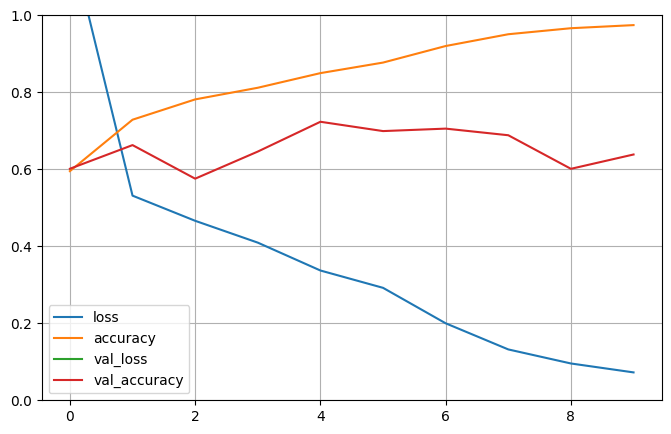

In [18]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [14]:
pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.5 MB/s eta 0:00:00


In [3]:
import keras_tuner as kt

In [25]:
def model_build(hp):
  model = Sequential()
  model.add(Conv2D(filters=hp.Int('con_filter_1',min_value=32,max_value=128,step=16),
                   kernel_size=hp.Choice('kernel_size',values=[3,5]),
                   strides=hp.Choice('strides',values=[1,2]),
                   padding='valid',activation='relu',input_shape=(256,256,3)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

  model.add(Conv2D(filters=hp.Int('con_filter_2',min_value=32,max_value=64,step=16),
                   kernel_size=hp.Choice('kernel_size',values=[3,5]),
                   strides=hp.Choice('strides',values=[1,2]),
                   padding='valid',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

  model.add(Conv2D(
                  filters=hp.Int('con_filter_3',min_value=16,max_value=32,step=16),
                  kernel_size=hp.Choice('kernel_size',values=[3,5]),
                  strides=hp.Choice('strides',values=[1,2]),
                  padding='valid',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

  model.add(Flatten())

  model.add(Dense(hp.Choice('units_1',values=[32,64,128]),activation='relu'))
  model.add(Dropout(hp.Choice(
                'dropout_1',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  )))
  model.add(Dense(
                  hp.Choice('units_2',values=[16,32,64]),
                  activation='relu'
  ))
  model.add(Dropout(
                hp.Choice(
                'dropout_2',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  )))
  model.add(Dense(1,activation='sigmoid'))
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2,1e-3]))
                ,loss='binary_crossentropy',metrics=['accuracy'])
  return model


In [15]:
from keras_tuner import RandomSearch

In [26]:
tuner=RandomSearch(model_build,objective='val_accuracy',max_trials=5,directory='project',project_name='dogs_vs_cats')

In [27]:
tuner.search(train_ds,epochs=5,validation_data=test_ds)

Trial 5 Complete [00h 11m 12s]
val_accuracy: 0.5302000045776367

Best val_accuracy So Far: 0.5302000045776367
Total elapsed time: 00h 36m 29s


In [28]:
tuner.get_best_hyperparameters()[0].values

{'con_filter_1': 96,
 'kernel_size': 5,
 'strides': 1,
 'con_filter_2': 32,
 'con_filter_3': 32,
 'units_1': 64,
 'dropout_1': 0.9,
 'units_2': 32,
 'dropout_2': 0.8,
 'learning_rate': 0.01}

In [29]:
model=tuner.get_best_models(num_models=1)[0]

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 96)      7296      
                                                                 
 batch_normalization (Batch  (None, 252, 252, 96)      384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 96)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      76832     
                                                                 
 batch_normalization_1 (Bat  (None, 122, 122, 32)      128       
 chNormalization)                                                
                                                        

In [31]:
history=model.fit(train_ds,epochs=10,validation_data=test_ds,initial_epoch=5)

Epoch 6/10
625/625 [==============================] - 105s 163ms/step - loss: 0.6941 - accuracy: 0.4948 - val_loss: 1.6707 - val_accuracy: 0.5184
Epoch 7/10
625/625 [==============================] - 103s 164ms/step - loss: 0.6948 - accuracy: 0.4981 - val_loss: 4.0242 - val_accuracy: 0.5356
Epoch 8/10
625/625 [==============================] - 101s 162ms/step - loss: 0.6963 - accuracy: 0.4976 - val_loss: 6.5732 - val_accuracy: 0.5122
Epoch 9/10
625/625 [==============================] - 103s 164ms/step - loss: 0.6935 - accuracy: 0.4953 - val_loss: 10.6307 - val_accuracy: 0.5142
Epoch 10/10
625/625 [==============================] - 102s 163ms/step - loss: 0.6940 - accuracy: 0.4994 - val_loss: 2.2727 - val_accuracy: 0.5012


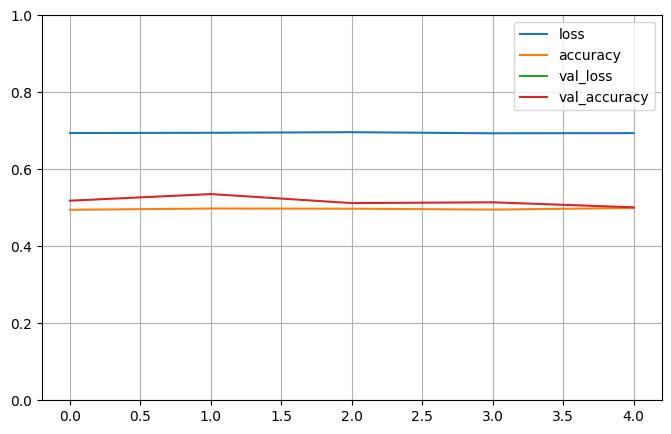

In [33]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [3]:
# prompt: load mnist dataset

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


11490434/11490434 [==============================] - 0s 0us/step


In [35]:
x_train.shape

(60000, 28, 28)

In [6]:
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(10,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(5,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10,activation='softmax'))

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_3 (Bat  (None, 26, 26, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_4 (Bat  (None, 11, 11, 64)        256       
 chNormalization)                                                
                                                      

In [8]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [9]:
model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

Epoch 1/5
1875/1875 [==============================] - 84s 44ms/step - loss: 0.7264 - accuracy: 0.7343 - val_loss: 0.1533 - val_accuracy: 0.9721
Epoch 2/5
1875/1875 [==============================] - 79s 42ms/step - loss: 0.4673 - accuracy: 0.8278 - val_loss: 0.1346 - val_accuracy: 0.9783
Epoch 3/5
1875/1875 [==============================] - 82s 44ms/step - loss: 0.4229 - accuracy: 0.8529 - val_loss: 0.1353 - val_accuracy: 0.9756
Epoch 4/5
1875/1875 [==============================] - 78s 42ms/step - loss: 0.3878 - accuracy: 0.8734 - val_loss: 0.1299 - val_accuracy: 0.9794
Epoch 5/5
1875/1875 [==============================] - 81s 43ms/step - loss: 0.3697 - accuracy: 0.8800 - val_loss: 0.1398 - val_accuracy: 0.9705


In [11]:
def model_build(hp):
  model = Sequential()
  model.add(Conv2D(filters=hp.Int('con_filter_1',min_value=32,max_value=128,step=16),
                   kernel_size=hp.Choice('kernel_size',values=[3,5]),
                   strides=hp.Choice('strides',values=[1,2]),
                   padding='valid',activation='relu',input_shape=(28,28,1)))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

  model.add(Conv2D(filters=hp.Int('con_filter_2',min_value=32,max_value=64,step=16),
                   kernel_size=hp.Choice('kernel_size',values=[3,5]),
                   strides=hp.Choice('strides',values=[1,2]),
                   padding='valid',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

  model.add(Conv2D(
                  filters=hp.Int('con_filter_3',min_value=16,max_value=32,step=16),
                  kernel_size=hp.Choice('kernel_size',values=[3,5]),
                  strides=hp.Choice('strides',values=[1,2]),
                  padding='valid',activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

  model.add(Flatten())

  model.add(Dense(hp.Choice('units_1',values=[32,64,128]),activation='relu'))
  model.add(Dropout(hp.Choice(
                'dropout_1',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  )))
  model.add(Dense(
                  hp.Choice('units_2',values=[16,32,64]),
                  activation='relu'
  ))
  model.add(Dropout(
                hp.Choice(
                'dropout_2',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
  )))
  model.add(Dense(10,activation='softmax'))
  model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2,1e-3]))
                ,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  return model


In [16]:
tuner=RandomSearch(model_build,objective='val_accuracy',max_trials=3,directory='project_1',project_name='mnist')

In [17]:
tuner.search(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

Trial 3 Complete [00h 05m 47s]
val_accuracy: 0.9776999950408936

Best val_accuracy So Far: 0.9776999950408936
Total elapsed time: 00h 05m 49s


In [18]:
tuner.get_best_hyperparameters()[0].values

{'con_filter_1': 32,
 'kernel_size': 3,
 'strides': 1,
 'con_filter_2': 48,
 'con_filter_3': 16,
 'units_1': 128,
 'dropout_1': 0.1,
 'units_2': 16,
 'dropout_2': 0.2,
 'learning_rate': 0.01}

In [19]:
model=tuner.get_best_models(num_models=1)[0]

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 48)        13872     
                                                                 
 batch_normalization_1 (Bat  (None, 11, 11, 48)        192       
 chNormalization)                                                
                                                        

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from seaborn import heatmap

In [21]:
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test),initial_epoch=5)

Epoch 6/10
1875/1875 [==============================] - 71s 36ms/step - loss: 0.1123 - accuracy: 0.9712 - val_loss: 0.1047 - val_accuracy: 0.9755
Epoch 7/10
1875/1875 [==============================] - 72s 38ms/step - loss: 0.1102 - accuracy: 0.9709 - val_loss: 0.1097 - val_accuracy: 0.9753
Epoch 8/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.1004 - accuracy: 0.9740 - val_loss: 0.1194 - val_accuracy: 0.9783
Epoch 9/10
1875/1875 [==============================] - 72s 38ms/step - loss: 0.1017 - accuracy: 0.9732 - val_loss: 0.1087 - val_accuracy: 0.9789
Epoch 10/10
1875/1875 [==============================] - 69s 37ms/step - loss: 0.0954 - accuracy: 0.9748 - val_loss: 0.1076 - val_accuracy: 0.9751


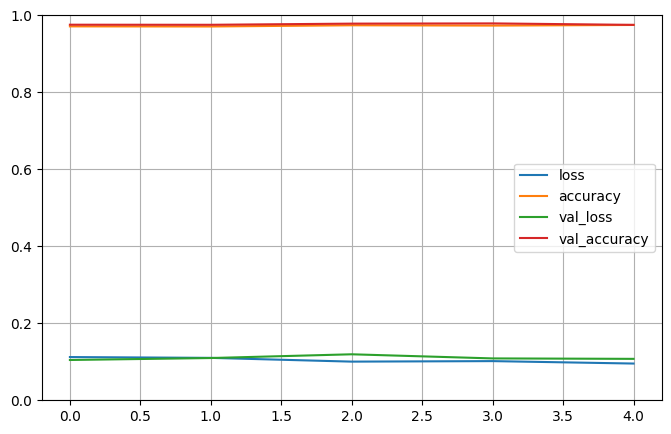

In [29]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [25]:
y_hat=model.predict(x_test).argmax(axis=1)

313/313 [==============================] - 4s 10ms/step


In [26]:
y_hat

array([7, 2, 1, ..., 4, 5, 6])

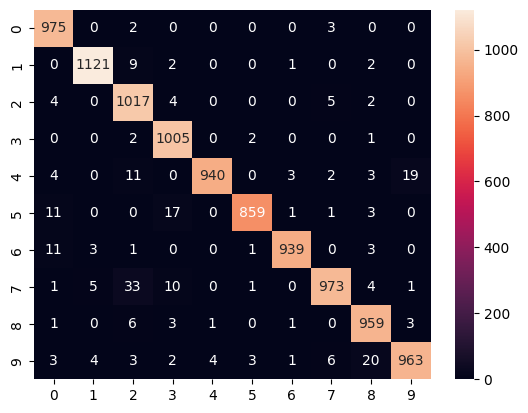

In [27]:
heatmap(confusion_matrix(y_test,y_hat),annot=True,fmt='d')
plt.show()

In [28]:
classification_report(y_test,y_hat)

'              precision    recall  f1-score   support\n\n           0       0.97      0.99      0.98       980\n           1       0.99      0.99      0.99      1135\n           2       0.94      0.99      0.96      1032\n           3       0.96      1.00      0.98      1010\n           4       0.99      0.96      0.98       982\n           5       0.99      0.96      0.98       892\n           6       0.99      0.98      0.99       958\n           7       0.98      0.95      0.96      1028\n           8       0.96      0.98      0.97       974\n           9       0.98      0.95      0.97      1009\n\n    accuracy                           0.98     10000\n   macro avg       0.98      0.97      0.98     10000\nweighted avg       0.98      0.98      0.98     10000\n'

In [32]:
model.predict(x_test[0].reshape(1,28,28,1)).argmax(axis=1)

1/1 [==============================] - 0s 148ms/step


array([7])

In [33]:
y_test[0]

7

In [35]:
for i in range(10):
  print("Predicted value:",model.predict(x_test[i].reshape(1,28,28,1)).argmax(axis=1)[0])
  print("Actual value:",y_test[i])
  print("*"*20)

1/1 [==============================] - 0s 126ms/step
Predicted value: 7
Actual value: 7
********************
1/1 [==============================] - 0s 74ms/step
Predicted value: 2
Actual value: 2
********************
1/1 [==============================] - 0s 111ms/step
Predicted value: 1
Actual value: 1
********************
1/1 [==============================] - 0s 52ms/step
Predicted value: 0
Actual value: 0
********************
1/1 [==============================] - 0s 34ms/step
Predicted value: 4
Actual value: 4
********************
1/1 [==============================] - 0s 33ms/step
Predicted value: 1
Actual value: 1
********************
1/1 [==============================] - 0s 47ms/step
Predicted value: 7
Actual value: 4
********************
1/1 [==============================] - 0s 33ms/step
Predicted value: 9
Actual value: 9
********************
1/1 [==============================] - 0s 55ms/step
Predicted value: 5
Actual value: 5
********************
1/1 [=====================